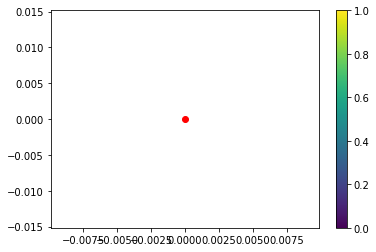

In [5]:
import zarr
import pandas as pd
from pyquaternion import Quaternion
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from buffer.util import rotate_origin_only
from ipywidgets import interactive
import cv2

rgb = np.uint8(zarr.open('/Users/nimit/Documents/robomaster/habitat/000200/rgb', mode='r')[:])
sem = (np.isin(np.uint8(zarr.open('/Users/nimit/Documents/robomaster/habitat/000200/semantic', mode='r')[:]), [156, 57, 210, 215])).squeeze()
ep = pd.read_csv('/Users/nimit/Documents/robomaster/habitat/000200/episode.csv')

x, y, z = np.float64(np.load('../floorplans/frl_apartment_4-floorplan.npy')[:100000].T)
points = np.stack([x, y, z], axis=-1)
points = points[np.isclose(points[:,1], ep.iloc[0]['y'])]

i = 0
centered = points-np.array(ep.iloc[i][['x','y','z']])
centered[:, [2,0]] = np.stack(
        rotate_origin_only(centered[:,2],centered[:,0],
        (0)+Quaternion(*np.array(ep.iloc[i][['i', 'j', 'k', 'l']])).angle), axis=-1)
# plt.scatter(*centered[:,[2,0]].T, c=centered[:,1], s=0.5)
plt.scatter(0, 0, c='r')
plt.colorbar()
plt.show()

# points = points[:5000]

In [6]:
# sem = (np.uint8(zarr.open('/Users/nimit/Documents/robomaster/habitat/000200/semantic', mode='r')[:])).squeeze()
# plt.imshow(sem[7])

In [7]:
f = 384 / (2*np.tan(np.deg2rad(120/2)))
py = 0.25
cx = 192
cy = 80

def project(i):
    centered = points-np.array(ep.iloc[i][['x','y','z']])
    centered[:, [2,0]] = np.stack(
            rotate_origin_only(centered[:,2],centered[:,0],
            Quaternion(*np.array(ep.iloc[i][['i', 'j', 'k', 'l']])).angle), axis=-1)

    wty = (cy - (f/(-(centered[:,2])))*py)
    wtx = cx + ((centered[:,0])*(cy-wty))/py

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    ax[0].imshow(rgb[i])
    ax[0].scatter(wtx[wty<80], 160-wty[wty<80], alpha=0.5, s=2)
    ax[0].set_xlim(0, 384)
    ax[0].set_ylim(160, 0)
    ax[0].set_aspect('equal', adjustable='box')

    fpv = np.zeros((160, 384), dtype=np.bool)
    uv = np.int64(np.stack([wtx, 160-wty]))
    uv = uv[:,(uv[0]>=0)&(uv[0]<384)&(uv[1]>=0)&(uv[1]<160)&(uv[1]>=80)]
    fpv[uv[1], uv[0]] = 1
    fpv = cv2.dilate(np.uint8(fpv), np.ones((3,3), np.uint8), iterations=7).astype(np.bool)
    ax[1].imshow(rgb[i])
    # mask = np.ma.masked_where(sem[i] == 0, sem[i])
#     mask = np.ma.masked_where(fpv == 0, fpv)
    mask = np.ma.masked_where((sem[i]&fpv) == 0, (sem[i]&fpv))
    ax[1].imshow(mask, 'ocean', interpolation='none', alpha=0.5)
    ax[1].set_aspect('equal', adjustable='box')
    
interactive(project, i=(0, rgb.shape[0]-1))

interactive(children=(IntSlider(value=48, description='i', max=97), Output()), _dom_classes=('widget-interact'…

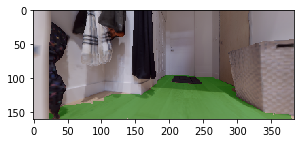

In [621]:


n, f = 0.001, 1000.
hfov = 120 * (np.pi / 180)
K = np.array([[1. / (np.tan(hfov / 2.)), 0., 0., 0.],
              [0., 1. / (np.tan(hfov / 2.)), 0., 0.],
              [0., 0., (n+f)/(n-f), (2*n*f)/(n-f)],
              [0., 0., -1, 0]])

def display(i):
    global wtx, wty
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
    ax[0].imshow(rgb[i])
    ax[0].imshow(np.ma.masked_where(sem[i] == 0, sem[i]), 'jet', interpolation='none', alpha=0.5)

    view = 2
    centered = points-np.array(ep.iloc[i][['x','y','z']])
    centered[:, [2,0]] = np.stack(
        rotate_origin_only(centered[:,2],centered[:,0],
        (np.pi/2)+Quaternion(*np.array(ep.iloc[i][['i', 'j', 'k', 'l']])).angle), axis=-1)
    centered = centered[(centered[:,2]>=-view)&(centered[:,2]<=view)&(centered[:,0]>=0)&(centered[:,0]<=view)]
    
    ax[1].scatter(centered[:,2], centered[:,0], s=2)
    ax[1].scatter(0, 0, c='r')
    ax[1].set_xlim(-view, view)
    ax[1].set_ylim(0, view)
    ax[1].set_aspect('equal', adjustable='box')

    wty = cy - (f/(centered[:,2]))*py
    wtx = cx + (centered[:,0]*(cy-wty))/py
    ax[2].scatter(wtx, wty)
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_xlim(0, 384)
    ax[2].set_ylim(160, 0)
    
#     whaty = (f / (cy-centered[:,0])) * py
#     whatx = ((centered[:,2]-cx)/(cy-centered[:,0])) * py
    
#     uv = np.matmul(np.linalg.inv(K), np.stack([centered[:,2], centered[:,0],
#         0.25*np.ones(centered.shape[0]), np.ones(centered.shape[0])]))
#     u, v = uv[:2]#/-1#uv[3,0]
# #     u = (u+1)*192
# #     v = (v)*80
    
#     ax[2].scatter(whatx,whaty)
#     ax[2].set_xlim(0, 384)
#     ax[2].set_ylim(0, 160)
#     ax[2].set_aspect('equal', adjustable='box')

interactive(display, i=(0, rgb.shape[0]-1))

interactive(children=(IntSlider(value=48, description='i', max=97), Output()), _dom_classes=('widget-interact'…

(-5000, 5000)

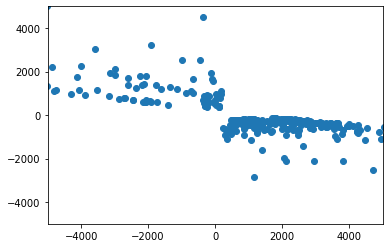

In [628]:
plt.scatter(wtx, wty)
plt.xlim(-5000, 5000)
plt.ylim(-5000, 5000)

(0, 160)

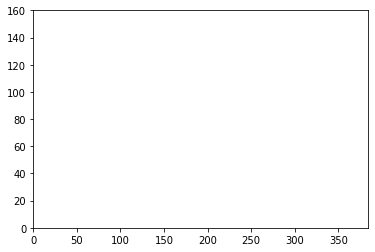

In [622]:
plt.scatter(wtx[wty<80], wty[wty<80])
plt.xlim(0, 384)
plt.ylim(0, 160)

In [ ]:
n, f = 0.001, 1000.
hfov = 120 * (np.pi / 180)
K = np.array([[n/192, 0., 0., 0.],
              [0., n/80, 0., 0.],
              [0., 0., -(f+n)/(f-n), (-2*n*f)/(f-n)],
              [0., 0., -1, 0]])

x, y, z, w = np.matmul(K, np.stack([-centered[:,2], centered[:,0],
    -0.25*np.ones(centered.shape[0]), np.ones(centered.shape[0])]))

x = np.clip(x, -w[0], w[0]) / w[0]
y = np.clip(y, -w[0], w[0]) / w[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2))
ax.scatter(y, x)
# ax.set_xlim(-0.0001, 0.0001)
# ax.set_ylim(0, 0.0001)
ax.set_aspect('equal', adjustable='box')

In [ ]:
hfov = 120 * (np.pi/180)
K = np.array([
    [1. / np.tan(hfov / 2.), 0., 0.],
    [0., 1. / np.tan(hfov / 2.), 0.],
    [0., 0.,  1.]])

u, v = np.where(sem[i])
uv1 = np.stack([u, v, np.ones(u.shape[0])])
x, y = np.matmul(np.linalg.inv(K), uv1)[:2][::-1]
plt.scatter(x, y)
# # plt.xlim(0, 384)
# plt.ylim(160, 0)

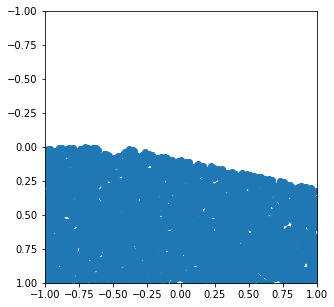

In [277]:
k = 4.
view = 1.

centered = points[np.isclose(points[:,1], ep.iloc[i]['y'], atol=2e-3)]-np.array(ep.iloc[i][['x','y','z']])
centered = centered[(np.abs(centered[:,0])<k)&(np.abs(centered[:,2])<k)]
centered[:, [2,0]] = np.stack(
    rotate_origin_only(centered[:,2],centered[:,0],
    -(np.pi)-Quaternion(*np.array(ep.iloc[i][['i', 'j', 'k', 'l']])).angle), axis=-1)
centered = centered[(centered[:,2]>=-view)&(centered[:,2]<=view)&(centered[:,0]>=0)&(centered[:,0]<=view)]
centered = centered[(np.abs(centered[:,2])<=2)&(centered[:,0]<=2)].T
centered = np.stack([centered[0], centered[2], centered[1]])

fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.scatter(centered[1], 1-centered[0])
ax.set_ylim(1, -1)
ax.set_xlim(-1, 1)
ax.set_aspect('equal', adjustable='box')

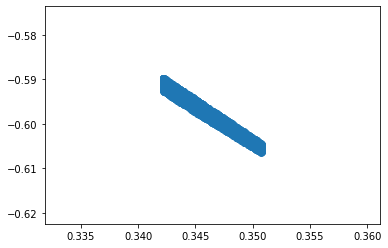

In [245]:
plt.scatter(whaty, whatx)

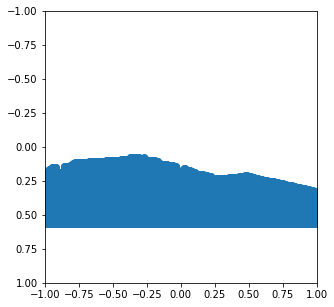

In [234]:
u, v = np.where(sem[i])
u = (u-80)/80
v = (v-192)/192

cam = np.stack([u, v, np.ones_like(u)])

hfov = 120 * (np.pi/180)
K = np.array([
    [1. / np.tan(hfov / 2.), 0., 0.],
    [0., 2.4 / np.tan(hfov / 2.), 0.],
    [0., 0.,  1.]])

fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

x, y, z = np.matmul(cam.T, K).T
ax.scatter(y, x)
ax.set_ylim(1, -1)
ax.set_xlim(-1, 1)
ax.set_aspect('equal', adjustable='box')

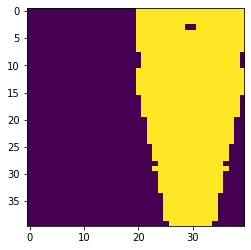

In [235]:
zoom = 20
_g = np.stack([y, x])
_g = centered[:,(np.abs(_c[1])<1)&(np.abs(_c[0])<1)]
gt  = np.zeros((2*zoom, 2*zoom), dtype=np.bool)
gt[np.int64(zoom*(_g[1]+1)), np.int64(zoom*(_g[0]+1))] = 1
# plt.imshow(gt)
 u
seg = np.zeros((2*zoom, 2*zoom), dtype=np.bool)
_c = centered
_c[0] = 1-_c[0]
_c = centered[:,(np.abs(_c[1])<1)&(np.abs(_c[0])<1)]
seg[np.int64(zoom*(_c[1]+1)), np.int64(zoom*(_c[0]+1))] = 1
# plt.imshow(seg)

plt.imshow(gt&seg)

In [ ]:
np.where(gt&seg)

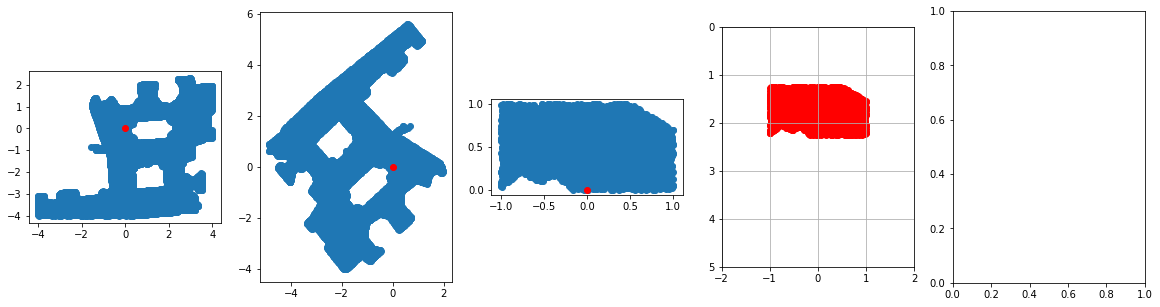

In [105]:
k = 4
view = 1.

centered = points[np.isclose(points[:,1], ep.iloc[i]['y'], atol=2e-3)]-np.array(ep.iloc[i][['x','y','z']])

fix, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

centered = centered[(np.abs(centered[:,0])<k)&(np.abs(centered[:,2])<k)]
ax[0].scatter(centered[:,2], centered[:,0])
ax[0].set_aspect('equal', adjustable='box')
ax[0].scatter(0, 0, c='r')

centered[:, [2,0]] = np.stack(
    rotate_origin_only(centered[:,2],centered[:,0],
    -(np.pi)-Quaternion(*np.array(ep.iloc[i][['i', 'j', 'k', 'l']])).angle), axis=-1)
ax[1].scatter(centered[:,2], centered[:,0])
ax[1].set_aspect('equal', adjustable='box')
ax[1].scatter(0, 0, c='r')

centered = centered[(centered[:,2]>=-view)&(centered[:,2]<=view)&(centered[:,0]>=0)&(centered[:,0]<=view)]
ax[2].scatter(centered[:,2], centered[:,0])
ax[2].set_aspect('equal', adjustable='box')
ax[2].scatter(0, 0, c='r')

# centered[:,0] *= 10
# centered[:,0] += 1.
# centered[:,2] -= 0.25
# centered[:,2] *= 2.4
centered = centered[(np.abs(centered[:,2])<=2)&(centered[:,0]<=2)].T
centered = np.stack([centered[0], centered[2], centered[1]])
ax[3].scatter(centered[1], (2.25)-centered[0], c='r') # y, x
ax[3].set_xlim(-2, 2)
ax[3].set_ylim(5, 0)
ax[3].set_aspect('equal', adjustable='box')

# x, y, z = np.matmul(cam.T, np.linalg.inv(K)).T
# ax[3].scatter(y, x, c='g', alpha=0.15)
ax[3].set_xlim(-2, 2)
ax[3].set_ylim(5, 0)
ax[3].set_aspect('equal', adjustable='box')
ax[3].grid(True)

In [17]:
u, v, _ = np.matmul(K, np.stack([x, y, z]))
u = np.int64(80*(u+1))
v = np.int64(192*(v+1))
fpv_gt = np.zeros((160, 384), dtype=np.bool)
fpv_gt[u,v] = 1
fpv_gt = cv2.dilate(np.uint8(fpv_gt), np.ones((2,2), np.uint8), iterations=2).astype(np.bool)

u, v, _ = np.matmul(K, np.stack([centered[0], centered[1], np.ones(centered.shape[1])]))
uv = np.stack([np.int64(80*(u+1)), np.int64(192*(v+1))])
u, v = uv[:,(uv[0]>=0)&(uv[0]<=159)&(uv[1]>=0)&(uv[1]<=383)]
fpv_sample = np.zeros((160, 384), dtype=np.bool)
fpv_sample[u,v] = 1
fpv_sample = cv2.dilate(np.uint8(fpv_sample), np.ones((2,2), np.uint8), iterations=2).astype(np.bool)

plt.imshow(rgb[i])
plt.imshow(np.ma.masked_where(fpv_gt&fpv_sample == 0, fpv_gt&fpv_sample), 'ocean', interpolation='none', alpha=0.5)
# plt.imshow(np.ma.masked_where(fpv_gt == 0, fpv_gt), 'ocean', interpolation='none', alpha=0.5)
# plt.imshow(np.ma.masked_where(fpv_sample == 0, fpv_sample), 'RdBu', interpolation='none', alpha=0.5)

NameError: name 'cv2' is not defined

In [3393]:
hfov = 120 * (np.pi / 180)
K = np.array([
    [1. / (np.tan(hfov / 2.)), 0., 0., 0.],
    [0., 1. / (np.tan(hfov / 2.)), 0., 0.],
    [0., 0.,  1., 0.]])

centered[:,1] = 0.25
xyz1 = np.ones((4, centered.shape[0]))
xyz1[:3] = centered.T
_x, _y, _z = np.matmul(K, xyz1)

uv = np.int64(np.stack([384*(_z+1), (160*_x)]))
u, v = uv[:,(uv[0]>=0)&(uv[0]<=383)&(uv[1]>=0)&(uv[1]<=159)]

fpv_sample = np.zeros((160, 384), dtype=np.bool)
fpv_sample[159-v, u] = 1
# fpv_sample = cv2.dilate(np.uint8(fpv_sample), np.ones((2,2), np.uint8), iterations=7).astype(np.bool)

plt.imshow(rgb[i])

mask = fpv_sample&sem[i]
plt.imshow(np.ma.masked_where(mask == 0, mask), 'ocean', interpolation='none', alpha=1.)

ValueError: could not broadcast input array from shape (19744,3) into shape (3,3)

In [ ]:
fpv_sample = np.zeros((160, 384), dtype=np.bool)
fpv_sample[159-u,v] = 1
fpv_sample = cv2.dilate(np.uint8(fpv_sample), np.ones((3,4), np.uint8), iterations=7).astype(np.bool)

plt.imshow(rgb[i])

mask = fpv_sample&sem[i]
plt.imshow(np.ma.masked_where(mask == 0, mask), 'ocean', interpolation='none', alpha=1.)

In [2977]:
n, f = 0.001, 1000.
hfov = 120 * (np.pi / 180)
K = np.array([[1. / (np.tan(hfov / 2.)), 0., 0., 0.],
              [0., 1. / (np.tan(hfov / 2.)), 0., 0.],
              [0., 0., (n+f)/(n-f), (2*n*f)/(n-f)],
              [0., 0., -1, 0]])

# centered[:,0] *= -1
# centered[:,1] = 0.25 # same as multiply by Rt with t = [0, 0.25, 0]
xyz1 = np.ones((4, centered.shape[0]))
xyz1[:3] = centered.T
np.matmul(xyz1.T, K).T

# print(v.min(), v.max())

# uv = np.stack([np.int64(80*u), np.int64(192*(v+1))])
# u, v = uv[:,(uv[0]>=0)&(uv[1]>=0)&(uv[0]<=159)&(uv[1]<=383)]

# plt.scatter(u, v)
# plt.xlim(0, 384)
# plt.ylim(0, 160)

array([[ 3.96554871e-01,  3.83682843e-01,  2.59535789e+00, ...,
         2.47615978e-01,  8.98613602e-01,  4.95086284e-01],
       [ 1.44337567e-01,  1.44337567e-01,  1.44337567e-01, ...,
         1.44337567e-01,  1.44337567e-01,  1.44337567e-01],
       [-1.52453861e+00,  2.24198426e+00,  4.58883738e-01, ...,
        -5.12141422e-03,  9.41660344e-01,  8.52410320e-02],
       [-1.04907617e-03,  6.48396204e-03,  2.91776456e-03, ...,
         1.98975518e-03,  3.88331681e-03,  2.17047989e-03]])

In [2798]:
np.matmul(K, xyz1)

array([[ 0.57735027,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.57735027,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.000002  , -0.002     ],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

In [2787]:
fpv_sample = np.zeros((160, 384), dtype=np.bool)
fpv_sample[159-u,v] = 1
fpv_sample = cv2.dilate(np.uint8(fpv_sample), np.ones((3,4), np.uint8), iterations=7).astype(np.bool)

plt.imshow(rgb[i])

mask = fpv_sample&sem[i]
plt.imshow(np.ma.masked_where(mask == 0, mask), 'ocean', interpolation='none', alpha=1.)

IndexError: index 18232 is out of bounds for axis 0 with size 160

In [2986]:
np.matmul(np.linalg.inv(K), np.array([1., 1., 1.]))

array([1.73205081, 1.73205081, 1.        ])

[ 0.52453756 -3.24197778 -1.45888082 ... -0.9948766  -1.94165646
 -1.08523886]


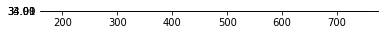

In [2982]:
hfov = 120 * (np.pi / 180)
K = np.array([
    [1. / np.tan(hfov / 2.), 0., 0.],
    [0., 1. / np.tan(hfov / 2.), 0.],
    [0., 0.,  1.]])

centered[:,1] += 0.25 # same as multiply by Rt with t = [0, 0.25, 0]
u, v, s = np.matmul(K, centered[:,[0,1,2]].T)
print(s)

u,v = np.stack([np.int64(192*(u+1)), np.int64(80*v)])
# u, v = uv[:,(uv[0]>=0)&(uv[0]<=383)&(uv[1]>=0)&(uv[1]<=159)]

fig, ax = plt.subplots(1,1)
ax.scatter(u, v)
# ax.set_xlim(0, 384)
# ax.set_ylim(0, 160)
ax.set_aspect('equal', adjustable='box')

In [2213]:
fpv_sample = np.zeros((160, 384), dtype=np.bool)
fpv_sample[159-v,u] = 1
fpv_sample = cv2.dilate(np.uint8(fpv_sample), np.ones((3,4), np.uint8), iterations=7).astype(np.bool)

plt.imshow(rgb[i])
plt.imshow(np.ma.masked_where(fpv_sample == 0, fpv_sample), 'ocean', interpolation='none', alpha=1.)

IndexError: arrays used as indices must be of integer (or boolean) type

In [2991]:
u.min()

90

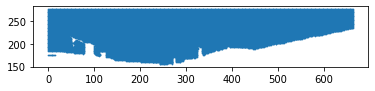

In [1436]:
pixels_per = 100
fpv_gt = np.zeros((pixels_per, 2*pixels_per), dtype=np.bool)
fpv_gt[np.int64(x*pixels_per), np.int64((y+1)*pixels_per)] = 1
plt.imshow(fpv_gt)

IndexError: index 1385 is out of bounds for axis 0 with size 100

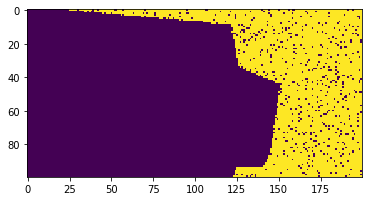

In [887]:
fpv_sample = np.zeros((pixels_per, 2*pixels_per), dtype=np.bool)
fpv_sample[np.int64(centered[:,1]*pixels_per), np.int64((centered[:,0]+1)*pixels_per)] = 1
plt.imshow(fpv_sample)

In [888]:
_x, _y = np.where(fpv_gt&fpv_sample)
_x = np.float32(_x)/pixels_per
_y = (np.float32(_y)/pixels_per)-1

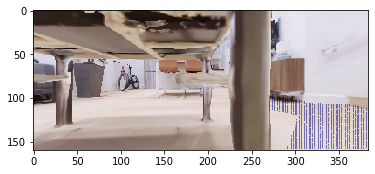

In [889]:
u, v, _ = np.int64(np.matmul(K, np.stack([_x, _y, np.ones(_x.shape[0])])))
fpv_fused = np.zeros((160, 384), dtype=np.bool)
fpv_fused[u+80, v+192] = 1

plt.imshow(rgb[i])
plt.imshow(np.ma.masked_where(fpv_fused == 0, fpv_fused), 'jet', interpolation='none', alpha=0.5)

In [588]:
import cv2

cv2.projectPoints

<function projectPoints>

In [874]:
u, v

(array([], dtype=int64), array([], dtype=int64))

(1, 0)

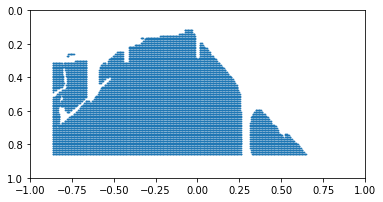

In [595]:
np.matmul(K, np.stack([x, y, z]))

array([[ 11.,  11.,  11., ...,  79.,  79.,  79.],
       [-17., -16., -15., ..., 142., 143., 144.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

(0, 160)

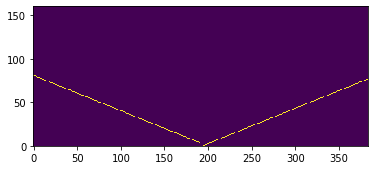

In [755]:
192*np.arctan(np.deg2rad(90-(120/2)))

visible = np.zeros((160, 384), dtype=np.bool)
visible[np.int64(slope*np.arange(0, 192)), np.arange(192, 384)] = 1
visible[80+np.int64(-slope*np.arange(0, 192)), np.arange(0, 192)] = 1

plt.imshow(visible)
plt.ylim(0, 160)

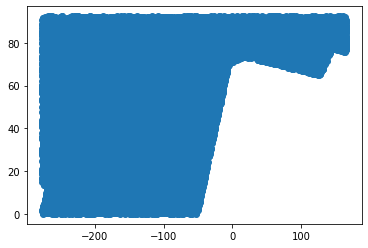

In [760]:
cameraMatrix = np.array([
    [160. / np.tan(hfov / 2.), 0., 80.],
    [0., 384. / np.tan(hfov / 2.), 192.],
    [0., 0.,  1]])

xyz = np.stack([centered[:,1], centered[:,0], np.zeros(centered.shape[0])])
rvec = np.array([[0.,0.,0]]) # no rotation
tvec = np.array([0., -.25, 0.])
uv, _ = cv2.projectPoints(xyz, rvec, tvec, K, None)

plt.scatter(*uv[:,0,::-1].T)
# plt.ylim(180, 0)

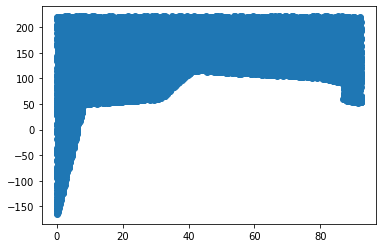

In [875]:
world = np.stack([centered[:,1], centered[:,0], np.ones(centered.shape[0])])
u, v, _ = np.matmul(K, world)
plt.scatter(u, v)

# fpv = np.zeros((160, 384), dtype=np.bool)
# x = np.clip(np.int64(u), 0, 159)
# y = np.clip(np.int64(v), 0, 383)
# fpv[x, y] = 1

# plt.imshow(rgb[i])
# plt.imshow(np.ma.masked_where(fpv == 0, fpv), 'jet', interpolation='none', alpha=0.5)